In [ ]:
import pandas as pd

# read the CSV
df = pd.read_csv('BirdsVoice.csv')

# compute total recordings per species
counts = df['common_name'].value_counts()
top20 = counts.nlargest(20).index

# filter to top 20 and reset index
df = df[df['common_name'].isin(top20)].reset_index(drop=True)
print(df.shape)            # ~600 × 10
print(df['common_name'].unique())


(600, 10)
['Brazilian Tinamou' 'Red-legged Tinamou' 'Yellow-legged Tinamou'
 'Black-capped Tinamou' 'Thicket Tinamou' 'Variegated Tinamou'
 "Bartlett's Tinamou" 'Small-billed Tinamou' 'Tataupa Tinamou'
 'Red-winged Tinamou' 'Andean Tinamou' 'White-bellied Nothura'
 'Spotted Nothura' 'Dwarf Tinamou' 'Orange-footed Scrubfowl'
 'Plain Chachalaca' 'Little Chachalaca' 'Band-tailed Guan' 'Andean Guan'
 'Rusty-margined Guan']


In [ ]:
import os

# convert “M:SS” → seconds
def length_to_seconds(x):
    m, s = x.split(':')
    return int(m) * 60 + int(s)

df['duration_s'] = df['recording_length'].apply(length_to_seconds)

# create filepaths you’ve downloaded into ./audio/, named by xc_id:
df['filepath'] = df['xc_id'].apply(lambda id: os.path.join('audio', f'{id}.mp3'))

# quick check
print(df[['filepath','duration_s']].head())

from sklearn.model_selection import train_test_split

# label encoding
label_map = {name:idx for idx,name in enumerate(top20)}
df['label'] = df['common_name'].map(label_map)

# 60/20/20 stratified split
trainval, test = train_test_split(df, test_size=0.20, 
                                  stratify=df['label'], random_state=42)
train, val   = train_test_split(trainval, test_size=0.25,  # 0.25×0.8 = 0.20
                                 stratify=trainval['label'], random_state=42)

print(train.shape, val.shape, test.shape)


             filepath  duration_s
0  audio/XC524787.mp3          57
1  audio/XC521357.mp3           6
2  audio/XC686176.mp3          53
3  audio/XC643154.mp3         140
4  audio/XC606110.mp3          42
(360, 13) (120, 13) (120, 13)


In [ ]:
import numpy as np
import librosa
import os

# Audio settings
SR = 22050  # sampling rate
DURATION = 5.0  # seconds to load/pad
N_MELS = 128  # number of mel bands

# Load an audio file, pad or truncate to exactly DURATION seconds,
# compute a N_MELS-band mel-spectrogram, convert to dB, and z-score normalize.
def extract_mel(path):
    try:
        # check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            return None
            
        # load (will truncate if longer than DURATION)
        y, _ = librosa.load(path, sr=SR, mono=True, duration=DURATION)
        
        # check if audio was loaded successfully
        if len(y) == 0:
            print(f"Empty audio file: {path}")
            return None
        
        # pad with zeros if too short
        target_len = int(SR * DURATION)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        
        # compute mel-spectrogram
        m = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS)
        m_db = librosa.power_to_db(m, ref=np.max)
        
        # Z-score normalization
        m_norm = (m_db - m_db.mean()) / (m_db.std() + 1e-6)
        
        return m_norm
        
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")
        return None


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf

# helper method to find the single .mp3 under audio/ matching an xc_id
def find_audio_path(xc_id):
    # recursive glob for e.g. audio/**/XC66646.mp3
    pattern = os.path.join('audio', '**', f'{xc_id}.mp3')
    matches = glob.glob(pattern, recursive=True)
    return matches[0] if matches else None

# rebuild df['filepath'] using the finder
df['filepath'] = df['xc_id'].apply(find_audio_path)

# report & drop missing
missing = df['filepath'].isna()
if missing.any():
    print(f"Warning: {missing.sum()} files not found, dropping those rows:")
    print(df.loc[missing, 'xc_id'].tolist())
    df = df[~missing].reset_index(drop=True)

# build_dataset now only sees real files and handles no file cases
def build_dataset(df_subset):
    X, y = [], []
    failed_files = []
    
    for _, row in df_subset.iterrows():  # Fixed: removed asterisks
        feat = extract_mel(row['filepath'])
        # skip if extraction failed (feat is None)
        if feat is None:
            failed_files.append(row['filepath'])
            continue
        X.append(feat[..., np.newaxis])  # → (128, T, 1)
        y.append(row['label'])
    
    if failed_files:
        print(f"Skipped {len(failed_files)} files that couldn't be loaded")
    
    if len(X) == 0:
        raise ValueError("No valid audio files found! Please check your file paths and audio files.")
    
    X = np.stack(X, axis=0)  # → (N, 128, T, 1)
    y = tf.keras.utils.to_categorical(
        y,
        num_classes=len(label_map)
    )
    return X, y

# apply to splits
X_train, y_train = build_dataset(train)
X_val,   y_val   = build_dataset(val)
X_test,  y_test  = build_dataset(test)

# size and input shape
input_shape = X_train.shape[1:]
print("Input shape:", input_shape)
print("Sizes (train/val/test):", X_train.shape[0],
      X_val.shape[0], X_test.shape[0])



['XC680227', 'XC23831']


Note: Illegal Audio-MPEG-Header 0x7972736f at offset 82464.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x2c20476f at offset 79329.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


File not found: audio/XC23831.mp3


Skipped 1 files that couldn't be loaded


File not found: audio/XC680227.mp3
Skipped 1 files that couldn't be loaded
Input shape: (128, 216, 1)
Sizes (train/val/test): 359 120 119


In [ ]:
from tensorflow.keras import layers, models
# define a cnn model
model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3,3), activation='relu'), # first conv layer: 3x3 kernel, 32 filters, ReLU activation
    layers.MaxPooling2D((2,2)), 
    
    layers.Conv2D(64, (3,3), activation='relu'), # second conv layer: 3x3 kernel, 64 filters, ReLU activation
    layers.MaxPooling2D((2,2)), 
    
    layers.Flatten(), # flatten to 1D
    layers.Dense(128, activation='relu'), # fully connected layer with 128 units and ReLU activation
    layers.Dense(len(label_map), activation='softmax'), # output layer with softmax for multi-class classification''-'['=]
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) # compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
# train model with validation data and early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=30,
    # stop training early if validation loss doesn't improve for 5 epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)] 
)


NameError: name 'input_shape' is not defined

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


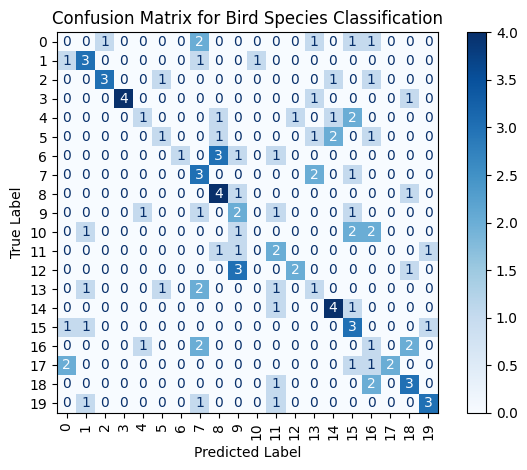

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# make accurate predictions on the test set
y_pred_probs = model.predict(X_test)             
y_pred = np.argmax(y_pred_probs, axis=1)          
y_true = np.argmax(y_test, axis=1)                

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix for Bird Species Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
